In [19]:
import sys
sys.path.append(".")

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.tools.visualization import plot_histogram
from scipy.optimize import minimize

import circuits

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 26

from IPython.display import Image

# Random walk on complete graph

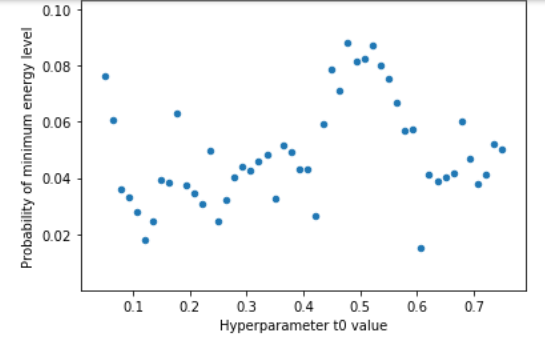

In [2]:
Image("../leonard_1.png")

# Random walk on line

# Simple walk

In [ ]:
n = 5
initial_position = 2
n_swipes = 3
phi = np.pi

#

excitations_qr = QuantumRegister(n)
excitations_cr = ClassicalRegister(n)
qc = QuantumCircuit(excitations_qr, excitations_cr)
qc.x(excitations_qr[initial_position])

qc += circuits.walk_step(excitations_qr, phi, initial_position, n_swipes)

qc.measure(excitations_qr, excitations_cr)

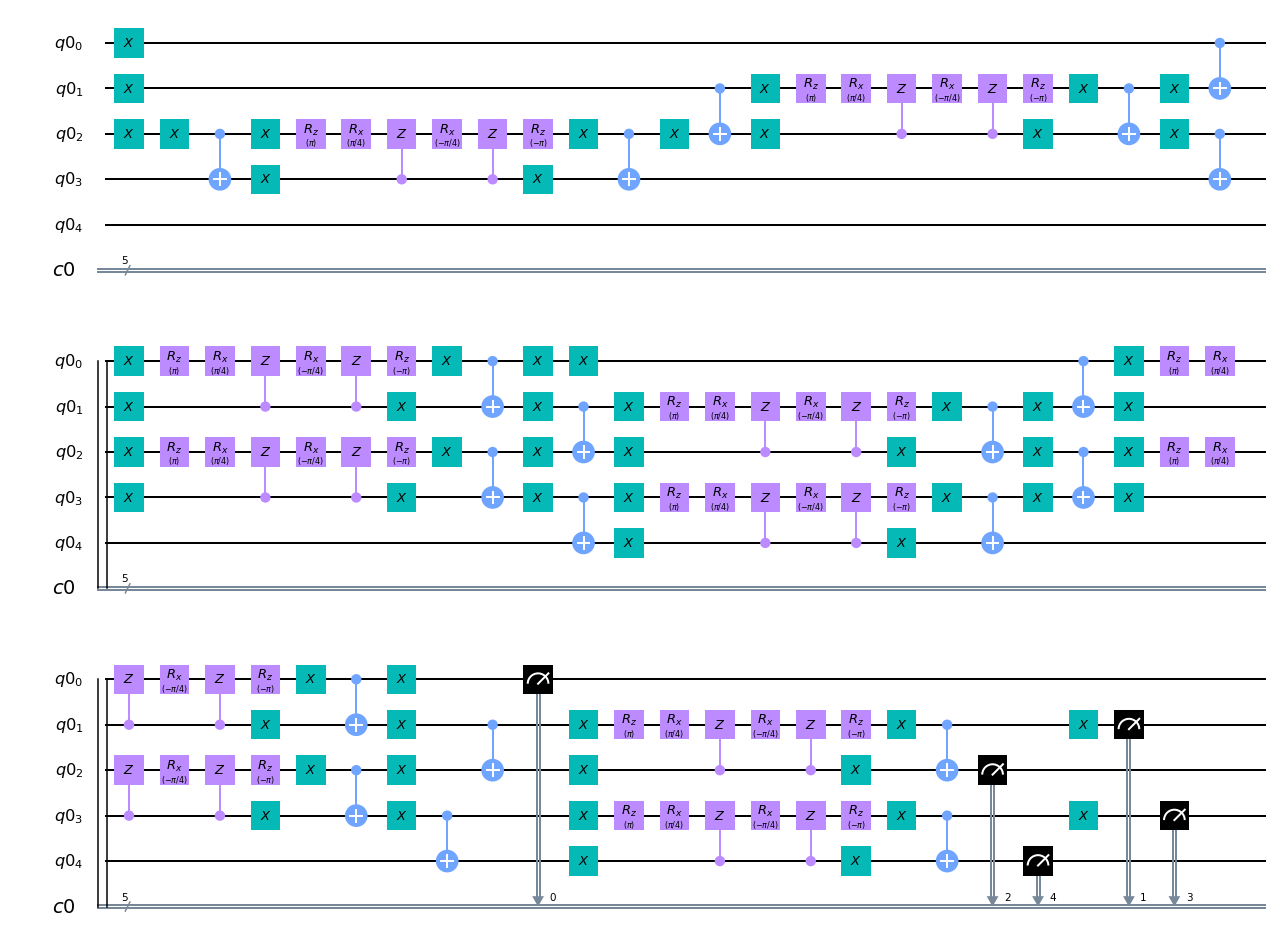

In [3]:
qc.draw(output="mpl")

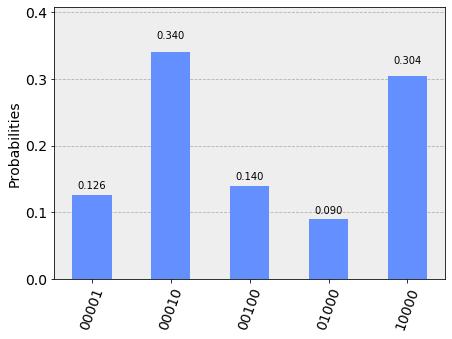

Process ForkProcess-7:
Process ForkProcess-4:
Process ForkProcess-8:
Process ForkProcess-6:
Process ForkProcess-3:
Process ForkProcess-5:
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
 

In [4]:
job = execute(qc, backend=BasicAer.get_backend("qasm_simulator"), shots=100000)
result = job.result()
plot_histogram(result.get_counts(qc))

# Walk with potential

In [85]:
n = 5
initial_position = 2
n_blocks = 3
phi = np.pi
potential = [ -3, 2, 0, 2, -5 ]
t = [ 2.18426252, -0.81823265,  0.50039038] #[ 0.1, 0.1, 0.1 ]

excitations_qr = QuantumRegister(n)
excitations_cr = ClassicalRegister(n)
qc = QuantumCircuit(excitations_qr, excitations_cr)
qc.x(excitations_qr[initial_position])

for block in range(n_blocks):
    qc += circuits.walk_step(excitations_qr, phi, initial_position, n_swipes)
    qc += circuits.potential_step(excitations_qr, potential, t[block])

qc.measure(excitations_qr, excitations_cr)

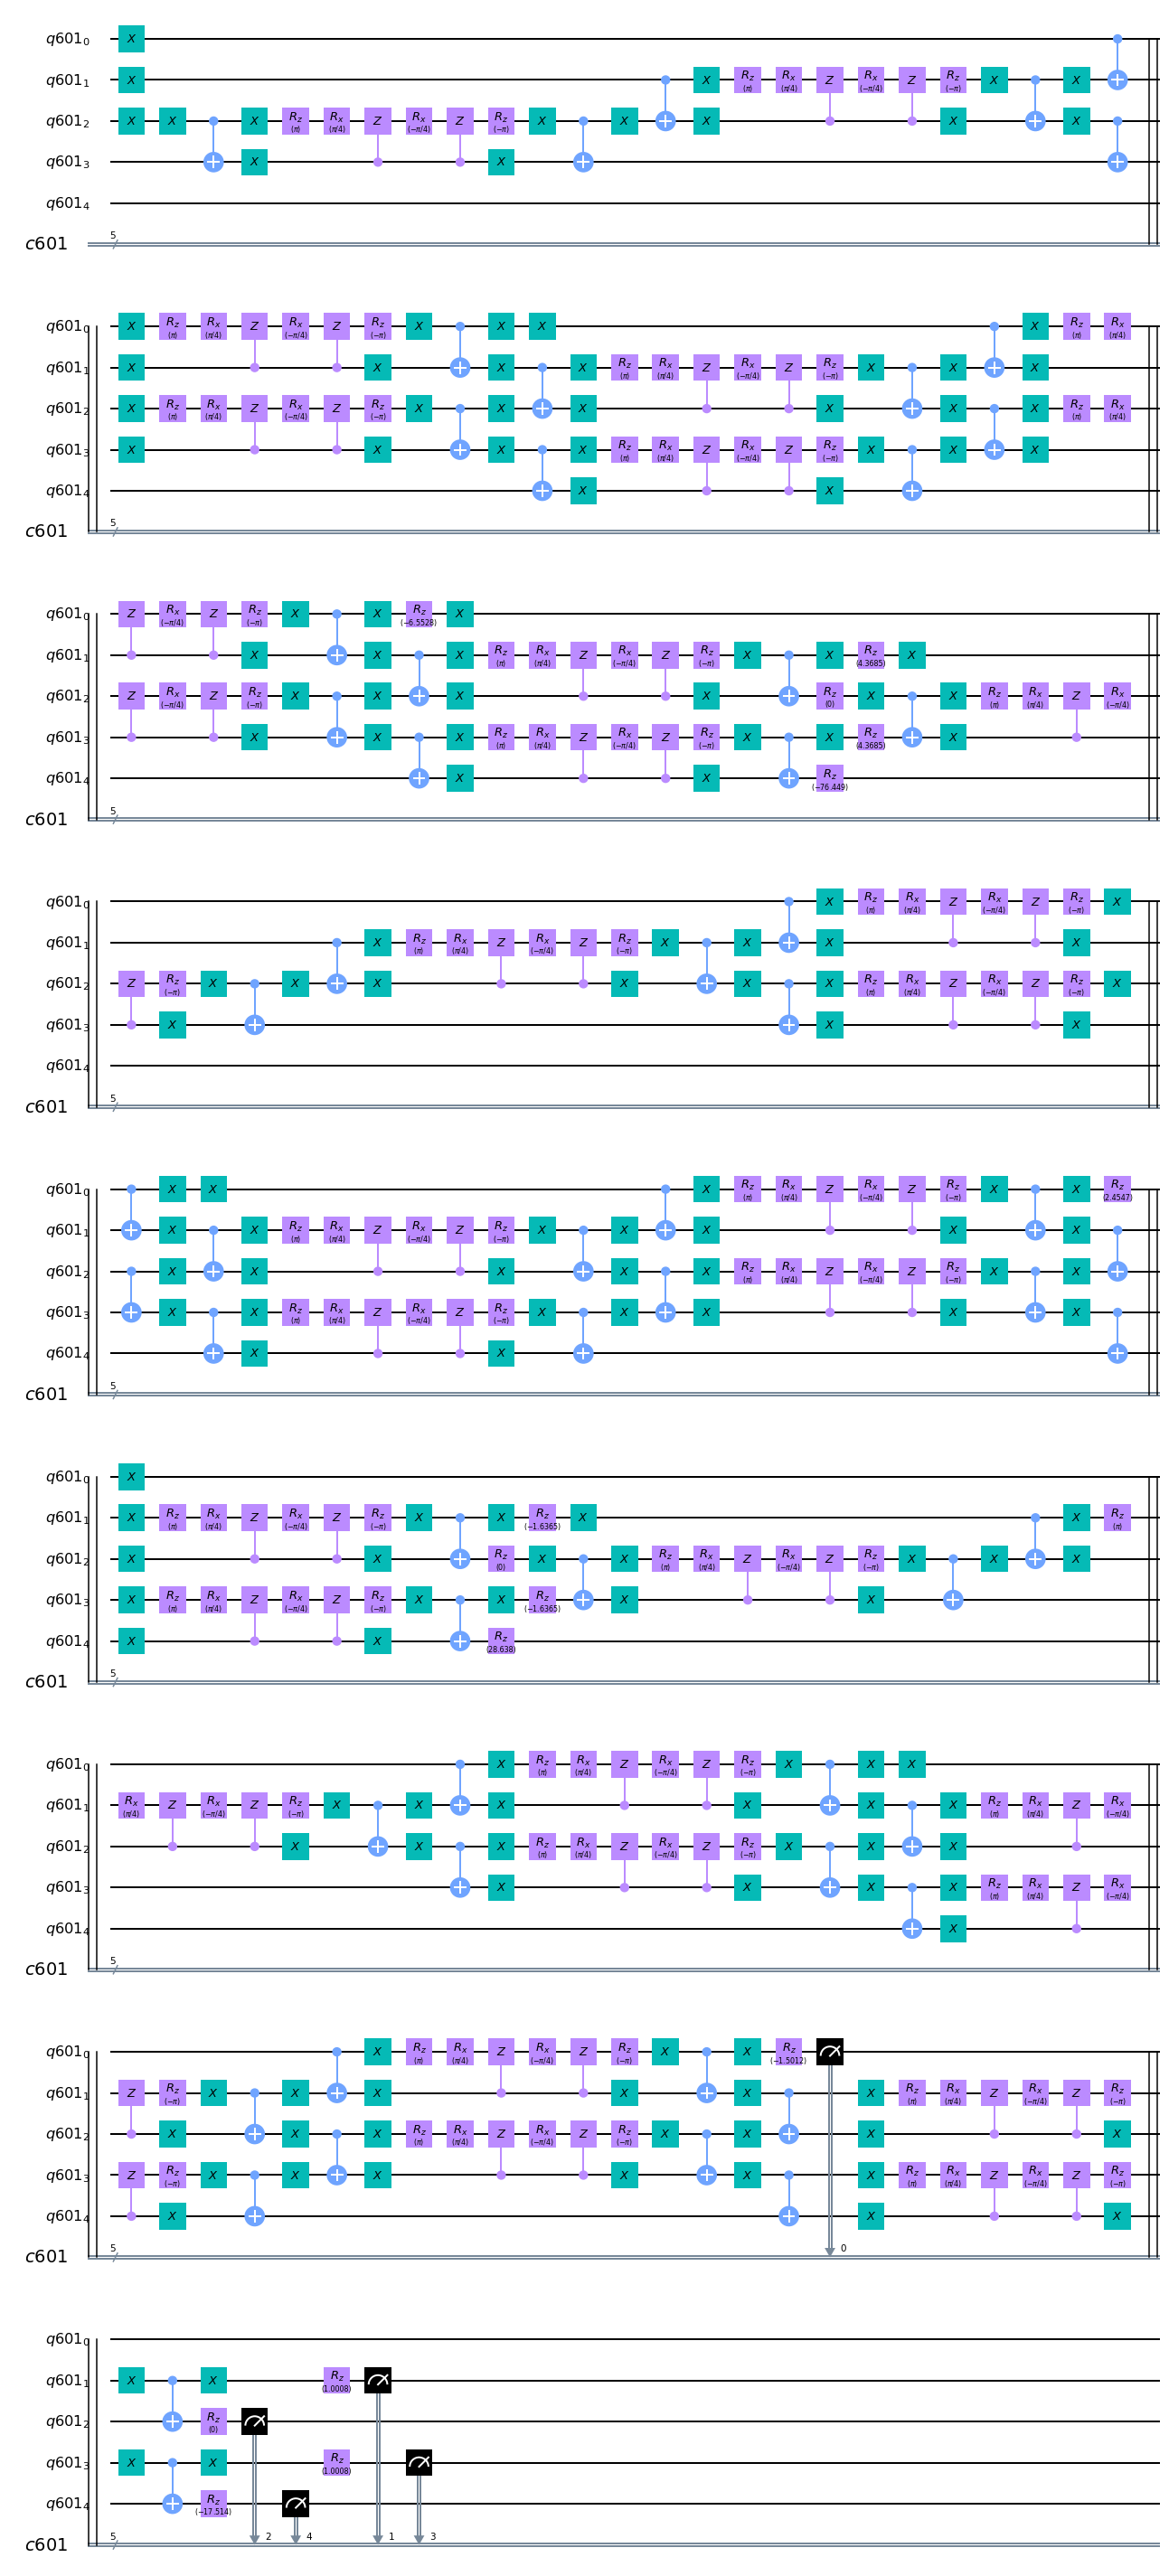

In [78]:
qc.draw(output="mpl")

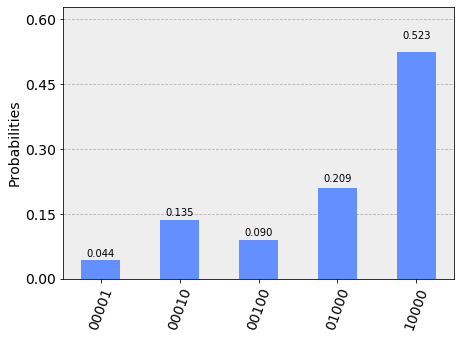

In [79]:
job = execute(qc, backend=BasicAer.get_backend("qasm_simulator"), shots=100000)
result = job.result()
plot_histogram(result.get_counts(qc))

# Optimized walk with potential

In [2]:
n = 5
initial_position = 2
n_blocks = 3
phi = np.pi
#potential = [ -3, 2, 0, 2, -35 ]

#

def expected_energy(t, potential):
    excitations_qr = QuantumRegister(n)
    excitations_cr = ClassicalRegister(n)
    qc = QuantumCircuit(excitations_qr, excitations_cr)
    qc.x(excitations_qr[initial_position])

    for block in range(n_blocks):
        qc += circuits.walk_step(excitations_qr, phi, initial_position, int(n / 2))
        qc += circuits.potential_step(excitations_qr, potential, t[block])

    qc.measure(excitations_qr, excitations_cr)
    
    job = execute(qc, backend=BasicAer.get_backend("qasm_simulator"), shots=100000)
    result = job.result()
    counts = { np.argwhere([ int(b) for b in bit_string ])[0, 0]: count for bit_string, count in result.get_counts(qc).items() }
    
    return np.sum([ potential[pos] * count for pos, count in counts.items() ]) / np.sum(list(counts.values()))


def probability_min(t, potential):
    excitations_qr = QuantumRegister(n)
    excitations_cr = ClassicalRegister(n)
    qc = QuantumCircuit(excitations_qr, excitations_cr)
    qc.x(excitations_qr[initial_position])

    for block in range(n_blocks):
        qc += circuits.walk_step(excitations_qr, phi, initial_position, int(n / 2))
        qc += circuits.potential_step(excitations_qr, potential, t[block])

    qc.measure(excitations_qr, excitations_cr)
    
    job = execute(qc, backend=BasicAer.get_backend("qasm_simulator"), shots=100000)
    result = job.result()
    counts = { np.argwhere([ int(b) for b in bit_string ])[0, 0]: count for bit_string, count in result.get_counts(qc).items() }
    
    argmin = np.argmin(potential)
    
    if argmin not in counts:
        print ("solution not found")
        return 0
    else:
        return counts[argmin] / np.sum(list(counts.values()))

In [11]:
opt_result = minimize(expected_energy, x0=(0.1,) * n_blocks, args=(potential), method="COBYLA", options={ "maxiter": 5 })

In [21]:
x_values = [ -25, -20, -15, -10, -5 ]
y_values = []
for x in x_values:
    print ("x = {}".format(x))
    opt_result = minimize(lambda t, potential: -probability_min(t, potential), x0=(0.1,) * n_blocks, args=([ -3, 2, 0, 2, x ]), method="COBYLA", options={ "maxiter": 25 })
    y_values.append(opt_result.fun)

x = -25
x = -20
x = -15
x = -10
x = -5


Text(0, 0.5, '$p_{\\mathrm{success}}$')

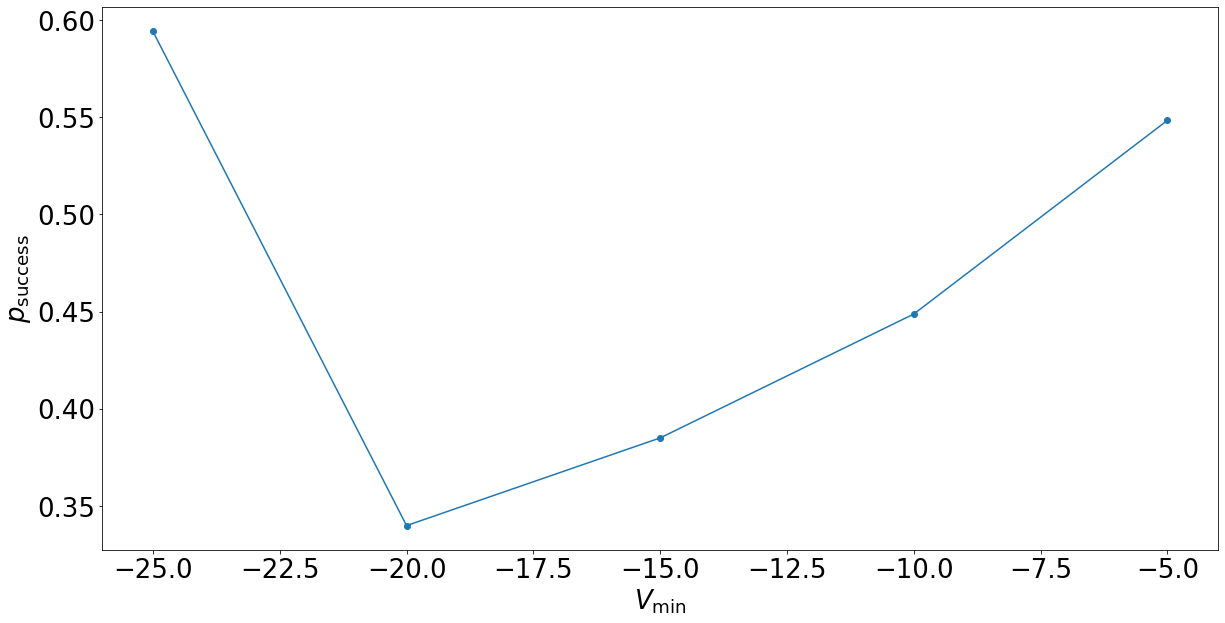

In [22]:
plt.plot(x_values, -np.array(y_values), "o-")
plt.xlabel("$V_{\\mathrm{min}}$")
plt.ylabel("$p_{\mathrm{success}}$")